In [1]:
from google.colab import files

# This will open a dialog to select the file from your device
uploaded = files.upload()

Saving DR_Model_2_1.zip to DR_Model_2_1.zip


In [2]:
import zipfile
import os

# Replace 'Exudates-3 (3)-new.zip' with the actual name of your uploaded file
zip_file = 'DR_Model_2_1.zip'

# Create a directory to extract the contents
extract_dir = '/content/extracted_exudates'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Navigate to the extracted folder
os.chdir(extract_dir)

# List the contents of the directory to confirm extraction
print("Extracted files:")
os.listdir(extract_dir)


Extracted files:


['DR_Model_2_1']

In [3]:
# Define paths for training, validation, and test datasets
train_dir = '/content/extracted_exudates/DR_Model_2_1/train'
valid_dir = '/content/extracted_exudates/DR_Model_2_1/valid'
test_dir = '/content/extracted_exudates/DR_Model_2_1/test'


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator instances for training, validation, and test datasets
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images with specified parameters
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to 224x224 for VGG19
    batch_size=32,
    class_mode='binary'  # Binary classification
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 14265 images belonging to 1 classes.
Found 1593 images belonging to 1 classes.
Found 799 images belonging to 1 classes.


In [5]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization

# Load VGG19 model pre-trained on ImageNet, excluding the top classification layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
# Initialize the Sequential model
model = Sequential()

# Add the base VGG19 model
model.add(base_model)

# Flatten the output from the base model
model.add(Flatten())

# Add custom layers to reach a total of 20 layers
# Including Flatten layer, Dense layers, Batch Normalization, and Dropout
model.add(Dense(512, activation='relu'))      # Layer 1
model.add(BatchNormalization())              # Layer 2
model.add(Dropout(0.5))                      # Layer 3
model.add(Dense(256, activation='relu'))     # Layer 4
model.add(BatchNormalization())              # Layer 5
model.add(Dropout(0.5))                      # Layer 6
model.add(Dense(128, activation='relu'))     # Layer 7
model.add(BatchNormalization())              # Layer 8
model.add(Dense(128, activation='relu'))     # Layer 9
model.add(BatchNormalization())              # Layer 10
model.add(Dropout(0.5))                      # Layer 11
model.add(Dense(64, activation='relu'))      # Layer 12
model.add(BatchNormalization())              # Layer 13
model.add(Dense(64, activation='relu'))      # Layer 14
model.add(BatchNormalization())              # Layer 15
model.add(Dropout(0.5))                      # Layer 16
model.add(Dense(32, activation='relu'))      # Layer 17
model.add(BatchNormalization())              # Layer 18
model.add(Dense(16, activation='relu'))      # Layer 19
model.add(BatchNormalization())              # Layer 20
model.add(Dense(1, activation='sigmoid'))    # Output layer (21st layer if counting outputs separately)


In [7]:
from tensorflow.keras.optimizers import Adam

# Compile the model with Adam optimizer and binary crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define EarlyStopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define ModelCheckpoint to save the best model during training
model_checkpoint = ModelCheckpoint('best_vgg19_model.keras', save_best_only=True, monitor='val_loss', mode='min')


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    epochs=11,  # Number of epochs
    callbacks=[early_stopping, model_checkpoint]  # Use callbacks
)


Epoch 1/11


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 48/445 ━━━━━━━━━━━━━━━━━━━━ 2:48:42 25s/step - accuracy: 0.5600 - loss: 0.7695

In [ ]:
# Evaluate the trained model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test accuracy: {test_acc}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 1.0000 - loss: 6.8305e-04
Test accuracy: 1.0


In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
import numpy as np

# Load the VGG19 model pre-trained on ImageNet
model = VGG19(weights='imagenet')


574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


In [ ]:
def preprocess_and_predict(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make prediction
    predictions = model.predict(img_array)
    decoded_predictions = decode_predictions(predictions, top=3)[0]  # Get top 3 predictions

    return decoded_predictions


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


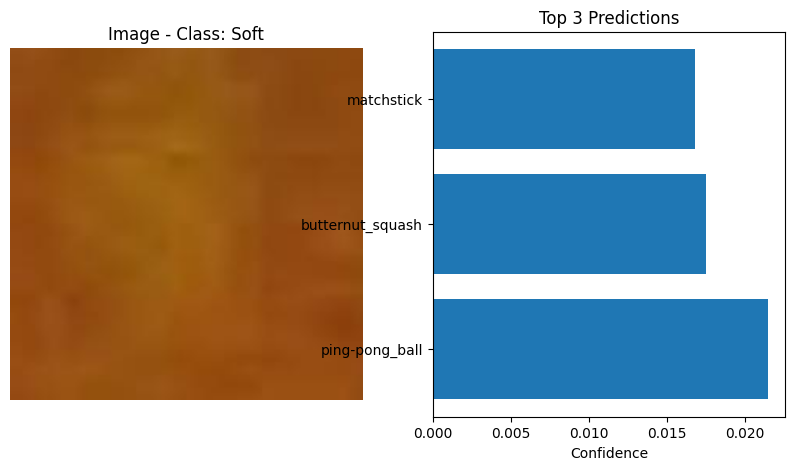

In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg19 import decode_predictions

# Define paths to the directories containing images for each class
soft_dir = '/content/extracted_exudates/DR_Model_2_1/test/output_test/Soft'   # Replace with your path
hard_dir = '/content/extracted_exudates/DR_Model_2_1/test/output_test/Hard'   # Replace with your path
no_ex_dir = '/content/extracted_exudates/DR_Model_2_1/test/output_test/No_ex' # Replace with your path

# Dictionary mapping class names to their respective directories
class_dirs = {
    'Soft': soft_dir,
    'Hard': hard_dir,
    'No_ex': no_ex_dir
}

# Randomly select a class
random_class = random.choice(list(class_dirs.keys()))

# Get all image files from the selected class directory
image_files = os.listdir(class_dirs[random_class])
# Filter to include only image files (e.g., .jpg, .png)
image_files = [f for f in image_files if f.endswith(('.png', '.jpg', '.jpeg'))]

# Randomly select an image from the class directory
random_image_file = random.choice(image_files)

# Load the selected image
img_path = os.path.join(class_dirs[random_class], random_image_file)
img = Image.open(img_path)

# Preprocess and make predictions
decoded_predictions = preprocess_and_predict(img_path)

# Display the image with the top predictions
plt.figure(figsize=(10, 5))

# Display the image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title(f'Image - Class: {random_class}')

# Display the top predictions
plt.subplot(1, 2, 2)
plt.barh([p[1] for p in decoded_predictions], [p[2] for p in decoded_predictions])
plt.xlabel('Confidence')
plt.title('Top 3 Predictions')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
15 random images have been downloaded to /content/downloaded_images
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━

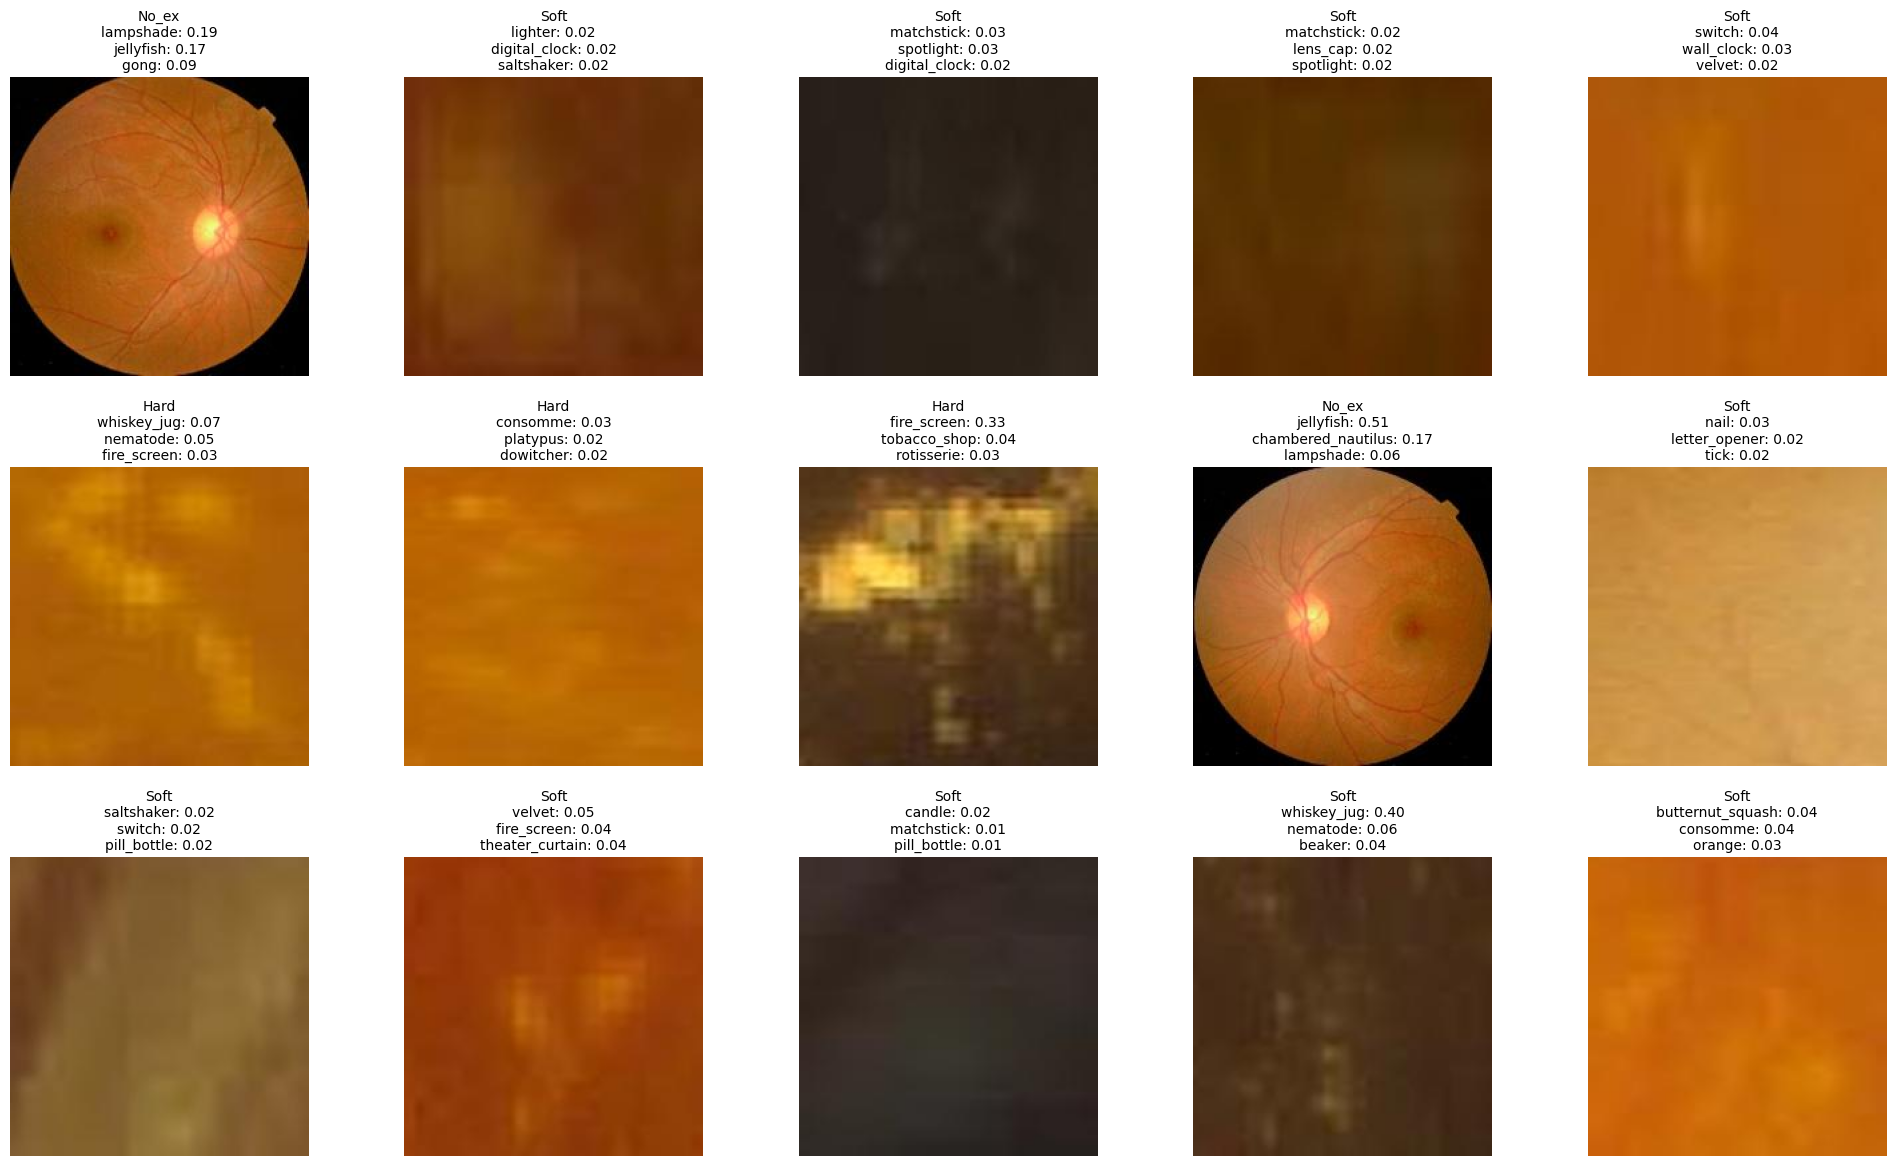

In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import shutil
import numpy as np
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions

# Define paths to the directories containing images for each class
soft_dir = '/content/extracted_exudates/DR_Model_2_1/test/output_test/Soft'   # Replace with your path
hard_dir = '/content/extracted_exudates/DR_Model_2_1/test/output_test/Hard'   # Replace with your path
no_ex_dir = '/content/extracted_exudates/DR_Model_2_1/test/output_test/No_ex' # Replace with your path

# Dictionary mapping class names to their respective directories
class_dirs = {
    'Soft': soft_dir,
    'Hard': hard_dir,
    'No_ex': no_ex_dir
}

# Collect all images from the directories
all_images = []
for class_name, dir_path in class_dirs.items():
    image_files = os.listdir(dir_path)
    image_files = [f for f in image_files if f.endswith(('.png', '.jpg', '.jpeg'))]  # Filter image files
    all_images.extend([(class_name, os.path.join(dir_path, img)) for img in image_files])

# Randomly select 15 images
random_images = random.sample(all_images, min(15, len(all_images)))  # Ensures it doesn't error if <15 images

# Directory to save the downloaded images
download_dir = '/content/downloaded_images'  # Change path if needed
os.makedirs(download_dir, exist_ok=True)

# Load the VGG19 model pre-trained on ImageNet
model = VGG19(weights='imagenet')

# Function to preprocess image and get predictions
def preprocess_and_predict(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make prediction
    predictions = model.predict(img_array)
    decoded_predictions = decode_predictions(predictions, top=3)[0]  # Get top 3 predictions

    return decoded_predictions

# Copy selected images to the download directory and predict
for class_name, img_path in random_images:
    # Generate a filename to avoid duplicates
    filename = f"{class_name}_{os.path.basename(img_path)}"
    save_path = os.path.join(download_dir, filename)
    shutil.copy(img_path, save_path)

    # Get predictions for the image
    predictions = preprocess_and_predict(img_path)
    # Save the predictions for later use
    with open(os.path.join(download_dir, f"{os.path.basename(img_path)}_predictions.txt"), 'w') as f:
        for pred in predictions:
            f.write(f"{pred[1]}: {pred[2]:.2f}\n")

print(f"15 random images have been downloaded to {download_dir}")

# Display the selected images with predictions in a clear format
plt.figure(figsize=(20, 12))
for i, (class_name, img_path) in enumerate(random_images):
    img = Image.open(img_path)
    plt.subplot(3, 5, i + 1)  # Arrange images in a 3x5 grid
    plt.imshow(img)
    plt.axis('off')

    # Get predictions for the image
    predictions = preprocess_and_predict(img_path)
    pred_text = "\n".join([f"{pred[1]}: {pred[2]:.2f}" for pred in predictions])

    # Display class name and predictions with clear formatting
    plt.title(f'{class_name}\n{pred_text}', fontsize=10, ha='center')

plt.tight_layout(pad=2.0)
plt.show()
